# Fourth assignment: Network Robustness

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections, itertools
#import cv2,os 
import plotly 
plotly.tools.set_credentials_file(username='franco.danilo', api_key='ecMyRQ2GXo5ZASr8AgFu')

import plotly.plotly as py
import plotly.graph_objs as go

from random import choice

## 0. Failure utilities

In [2]:
def execute_failures(graph, failureList):
    workingG = graph.copy()
    giant = max(nx.connected_component_subgraphs(workingG), key=len)
    diam_evol = [nx.diameter(giant)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [len(giant)]
    
    for node,_ in failureList:
        workingG.remove_node(node)
        if len(workingG)==0: break
        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        giant = max(nx.connected_component_subgraphs(workingG), key=len)
        if deg_evol[-1]>=1:
            giant_evol.append(len(giant))
            diam_evol.append(nx.diameter(giant))
        else:
            giant_evol.append(0)
            diam_evol.append(0)
            
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def plot_distribution2(distrDict, title):
    layout = go.Layout(
        title=go.layout.Title(text=title),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="# infections")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="# susceptibles")
        )
    )
    
    data = []
    for setting, suscList in distrDict.items():
        sizes = list(map(lambda pair:pair[1],suscList[1]))
        
        trace = go.Scatter(
            y=suscList[0],
            name=setting,
            text=list(map(lambda pair: "'{}' infected {}".format(pair[0],pair[1]),suscList[1])),#suscList[1],
            marker=dict(
                size=sizes,
                sizemode='area',
                sizeref=2.*max(sizes)/(50.**2),
                sizemin=5
            )
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename=title)

def plot_distribution(failDict, title):
    plt.figure(figsize=(15,8))
    plt.suptitle("{} failures evolution".format(title))
 
    plt.subplot(121)
    plt.plot(failDict["Diameter evolution"], label="Diameter evolution")
    plt.plot(failDict["Average degree evolution"], label="Average degree evolution")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()
    plt.grid()

    
    plt.subplot(122)
    plt.plot(failDict["Giant component evolution"], label="Giant component evolution")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()
    plt.grid()

    #plt.tight_layout()

In [3]:
def random_ranking(graph):
    return list(zip(np.random.permutation(graph.nodes()),range(1,graph.number_of_nodes()+1)))

def metric_ranking(metricFunction, graph, index=None):
    if index is None:
        metricDict = dict(metricFunction(graph))
    else:
        metricDict = dict(metricFunction(graph)[index])
    
    return sorted(metricDict.items(), key=lambda pair:pair[1], reverse=True)

## 1. Erdős-Rényi random graph [$G_{np}$]
<h4><li>$p>\frac{\log{n}}{n}$ </li></h4>

In [4]:
n = 500

In [5]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=7.004


/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



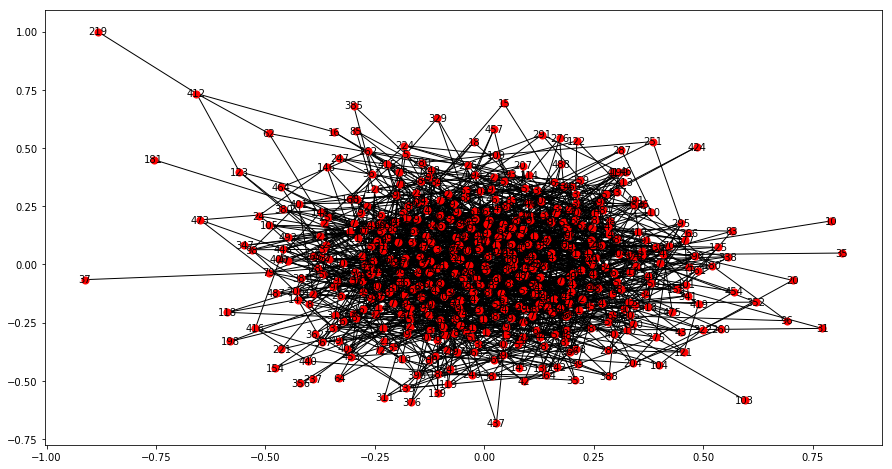

In [6]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [7]:
randomList = random_ranking(G)
#randomList

In [8]:
rand_failures = execute_failures(G, randomList)

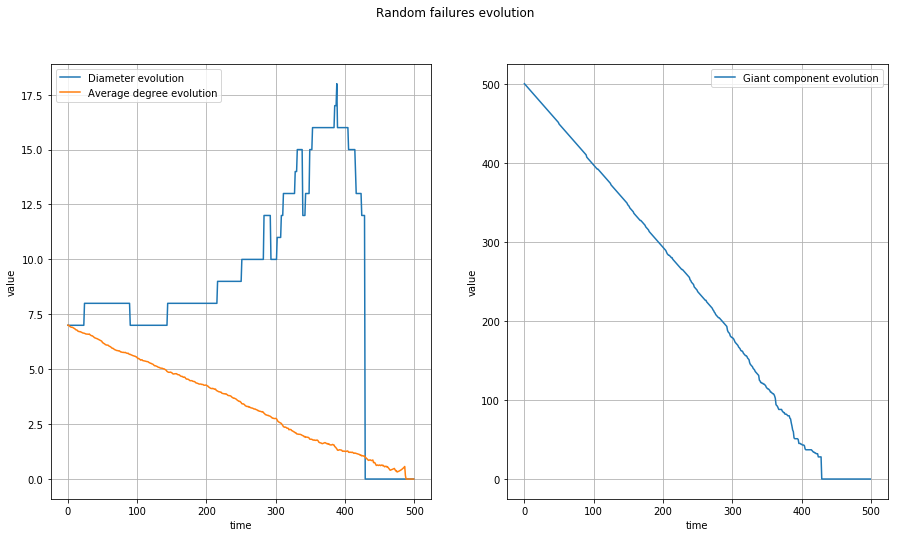

In [9]:
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [10]:
degList = metric_ranking(nx.degree, G)
#degList

In [11]:
deg_failures = execute_failures(G, degList)

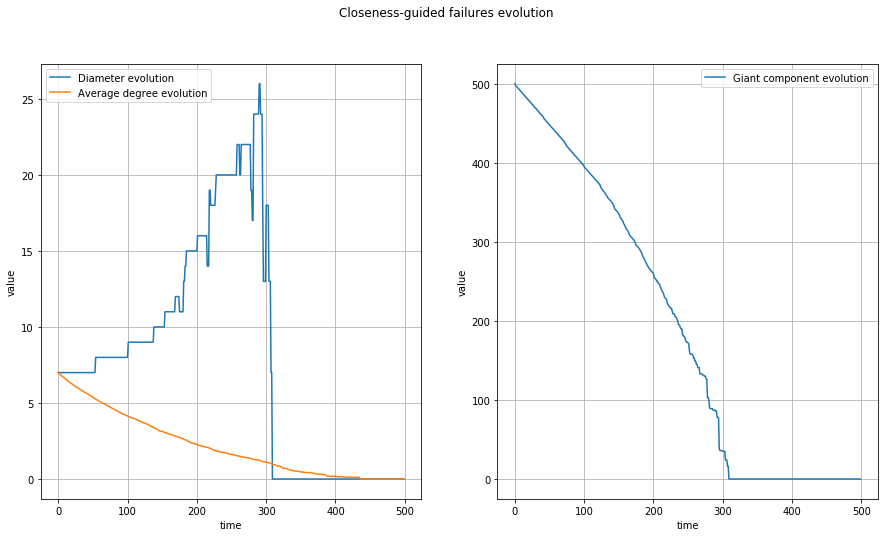

In [12]:
plot_distribution(deg_failures, "Closeness-guided")

### -- attacks over closeness

In [13]:
clsList = metric_ranking(nx.closeness_centrality, G)
#clsList

In [14]:
cls_failures = execute_failures(G, clsList)

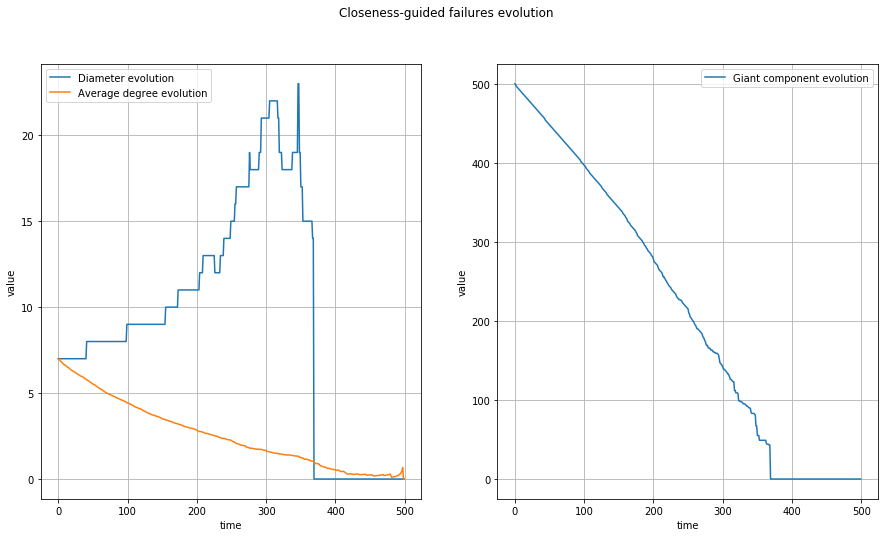

In [15]:
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweennes

In [16]:
btwList = metric_ranking(nx.betweenness_centrality, G)
#btwList

In [17]:
btw_failures = execute_failures(G, btwList)

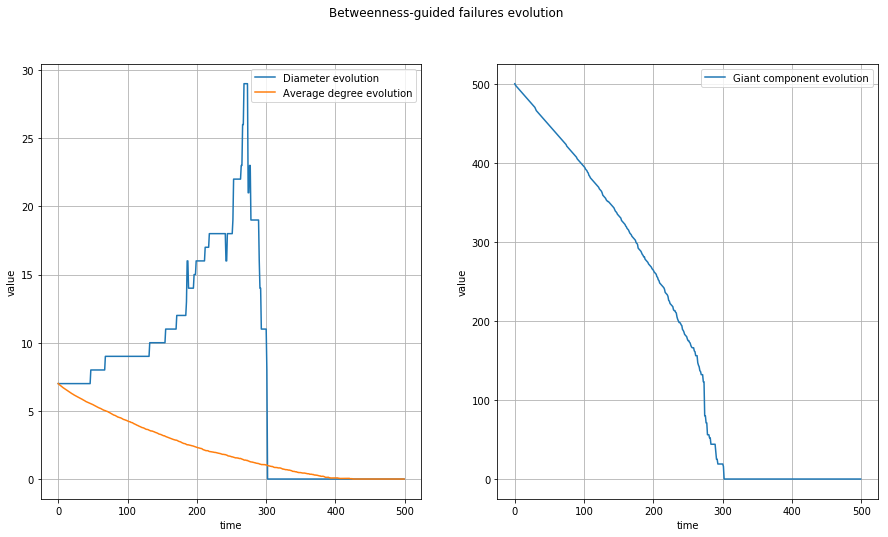

In [18]:
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [ ]:
cltList = metric_ranking(nx.clustering, G)
#randomFailures

In [ ]:
clt_failures = execute_failures(G, cltList)

In [ ]:
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prkList = metric_ranking(nx.pagerank_numpy, G)
#prkList

In [ ]:
prk_failures = execute_failures(G, prkList)

In [ ]:
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hitList = metric_ranking(nx.hits_numpy, G, index=0)
#hitList

In [ ]:
hit_failures = execute_failures(G, hitList)

In [ ]:
plot_distribution(hit_failures, "HITS-guided")

## 2. Power law network

In [ ]:
G = nx.powerlaw_cluster_graph(n,1,0.5)
#G = nx.scale_free_graph(n).to_undirected()
pos = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [ ]:
randomList = random_ranking(G)
#randomList

In [ ]:
rand_failures = execute_failures(G, randomList)

In [ ]:
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [ ]:
degList = metric_ranking(nx.degree, G)
#degList

In [ ]:
deg_failures = execute_failures(G, degList)

In [ ]:
plot_distribution(deg_failures, "Closeness-guided")

### -- attacks over closeness

In [ ]:
clsList = metric_ranking(nx.closeness_centrality, G)
#clsList

In [ ]:
cls_failures = execute_failures(G, clsList)

In [ ]:
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweennes

In [ ]:
btwList = metric_ranking(nx.betweenness_centrality, G)
#btwList

In [ ]:
btw_failures = execute_failures(G, btwList)

In [ ]:
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [ ]:
cltList = metric_ranking(nx.clustering, G)
#randomFailures

In [ ]:
clt_failures = execute_failures(G, cltList)

In [ ]:
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prkList = metric_ranking(nx.pagerank_numpy, G)
#prkList

In [ ]:
prk_failures = execute_failures(G, prkList)

In [ ]:
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hitList = metric_ranking(nx.hits_numpy, G, index=0)
#hitList

In [ ]:
hit_failures = execute_failures(G, hitList)

In [ ]:
plot_distribution(hit_failures, "HITS-guided")

## 3. Real Graph - arXiv collaboration on general relativity

In [ ]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random failures

In [ ]:
randomList = random_ranking(G)
#randomList

In [ ]:
rand_failures = execute_failures(G, randomList)

In [ ]:
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [ ]:
degList = metric_ranking(nx.degree, G)
#degList

In [ ]:
deg_failures = execute_failures(G, degList)

In [ ]:
plot_distribution(deg_failures, "Closeness-guided")

### -- attacks over closeness

In [ ]:
clsList = metric_ranking(nx.closeness_centrality, G)
#clsList

In [ ]:
cls_failures = execute_failures(G, clsList)

In [ ]:
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweennes

In [ ]:
btwList = metric_ranking(nx.betweenness_centrality, G)
#btwList

In [ ]:
btw_failures = execute_failures(G, btwList)

In [ ]:
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [ ]:
cltList = metric_ranking(nx.clustering, G)
#randomFailures

In [ ]:
clt_failures = execute_failures(G, cltList)

In [ ]:
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prkList = metric_ranking(nx.pagerank_numpy, G)
#prkList

In [ ]:
prk_failures = execute_failures(G, prkList)

In [ ]:
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hitList = metric_ranking(nx.hits_numpy, G, index=0)
#hitList

In [ ]:
hit_failures = execute_failures(G, hitList)

In [ ]:
plot_distribution(hit_failures, "HITS-guided")